# In depth: Manifold Learning

PCA is flexible, fast, and easily interpretable, it does not perform so well when there are nonlinear relationships within the data; we will see some examples of these below.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [7]:
# # Manifold Learning: ''HELLO'
# To make these concepts more clear, 
# let's start by generating some two-dimensional data that we can use to define a manifold. 
# Here is a function that will create data in the shape of the word "HELLO":
def make_hello(N=1000, rseed = 42):
    #make a plot with 'HELLO' text; sava as PNG
    fig, ax = plt.subplots(figsize = (4,1))
    fig.subplots_adjust(left = 0, right =1, bottom = 0, top =1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va = 'center', ha = 'center', weight = 'bold', size =85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    #Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1,:,0].T
    rng =np.random.RandomState(rseed)
    X = rng.rand(4*N, 2)
    i, j = (X*data.shape).astype(int).T
    mask =(data[i,j]<1)
    X = X[mask]
    
    X[:, 0] *= (data.shape[0] / data.shape[1])
    
    X=X[:N]
    
    return X[np.argsort(X[:,0])]
    
    

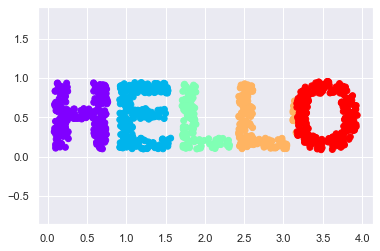

In [8]:
# Let's call the function and visualize the resulting data:
X = make_hello(1000)
colorize = dict(c = X[:,0], cmap =plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:,0], X[:,1], **colorize)
plt.axis('equal');

# Multidimensional Scaling (MDS)
Looking at data like this, we can see that the particular choice of x and y values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent. For example, if we use a rotation matrix to rotate the data, the x and y values change, but the data is still fundamentally the same:

(4.597858810380142, 8.755757454950324, 5.020644928025307, 7.258448710811383)

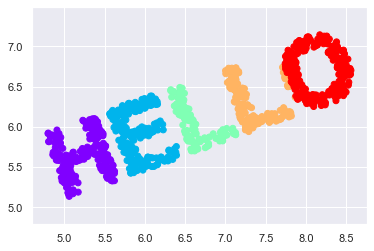

In [9]:
def rotate(X, angle):
    theta = np.deg2rad(angle) #use radius caculation
    R=[[np.cos(theta), np.sin(theta)],
      [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

#original data * rotation matrix= rotate data

X2 = rotate(X, 20) +5
plt.scatter(X2[:,0], X2[:, 1], **colorize)
plt.axis('equal')

This tells us that the x and y values are not necessarily fundamental to the relationships in the data. What is fundamental, in this case, is the distance between each point and the other points in the dataset. A common way to represent this is to use a distance matrix: for N points, we construct an N×N array such that entry (i,j) contains the distance between point i and point j. Let's use Scikit-Learn's efficient pairwise_distances function to do this for our original data:

In [11]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

As promised, for our N=1,000 points, we obtain a 1000×1000 matrix, which can be visualized as shown here:

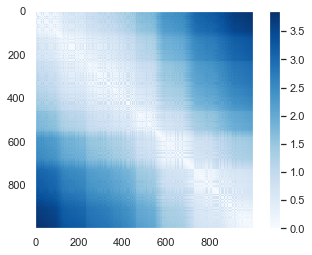

In [12]:
plt.imshow(D, zorder =2, cmap ='Blues', interpolation = 'nearest')
plt.colorbar();

If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:

In [13]:
D2= pairwise_distances(X2)
np.allclose(D, D2)  #D is pairwise_distance of X;

True

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive. In the representation shown in this figure, we have lost any visible sign of the interesting structure in the data: the "HELLO" that we saw before.

Further, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into x and y coordinates is rather difficult. This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a D-dimensional coordinate representation of the data. Let's see how it works for our distance matrix, using the precomputed dissimilarity to specify that we are passing a distance matrix:

(-1.0390064107727583,
 1.0377133989963168,
 -2.064666005451131,
 2.135458244484912)

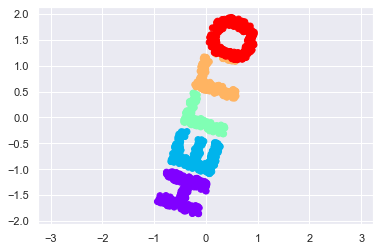

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components = 2, dissimilarity = 'precomputed', random_state =1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using only the N×N distance matrix describing the relationship between the data points.

# MDS as Manifold Learning
The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in any dimension. So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

In [16]:
def random_projection(X, dimension =3, rseed =42): #we can project 2D into 3D
    assert  dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C= rng.randn(dimension, dimension)  #Use the class to avoid impacting the global numpy state
    
    e, V = np.linalg.eigh(np.dot(C, C.T))   #Return the eigenvalues and eigenvectors of a Hermitian or symmetric matrix.
    return np.dot(X, V[:X.shape[1]])

X3= random_projection(X, 3)  #X.shape: (1000,2). 100个2D数据
X3.shape   #(1000, 3)


(1000, 3)

Let's visualize these oints to see what we're working with:


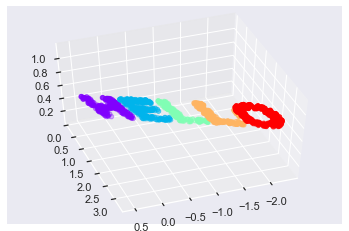

In [18]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection ='3d')
ax.scatter3D(X3[:,0], X3[:, 1], X3[:,2],
            **colorize)                                          #画三维散点图
ax.view_init(azim =70, elev =50)


We can now ask the MDS estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix. The result recovers a representation of the original data:

(-1.0390064107727621,
 1.0377133989963219,
 -2.0646660054511297,
 2.135458244484912)

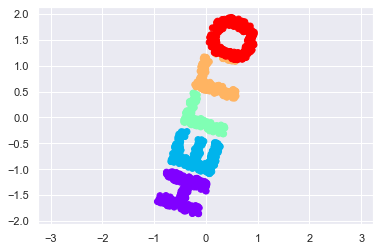

In [19]:
model = MDS(n_components =2, random_state =1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:,0], out3[:,1], **colorize)
plt.axis('equal')

This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data. In the case of MDS, the quantity preserved is the distance between every pair of points.

In [21]:
X.shape

(1000, 2)

# Nonlinear Embeddings: Where MDS Fails
Our discussion thus far has considered linear embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces. Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations. Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [23]:
def make_hello_s_curve(X):
    t=(X[:,0]-2)*0.75*np.pi   #原数据第一维轻微变形
    x = np.sin(t)                     #新的第一维
    y =X[:, 1]                          #第二维不变
    z = np.sign(t)*(np.cos(t)-1)  #第三维变化
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X) #(1000, 3)

This is again three-dimensional data, but we can see that the embedding is much more complicated:

In [24]:
XS.shape

(1000, 3)

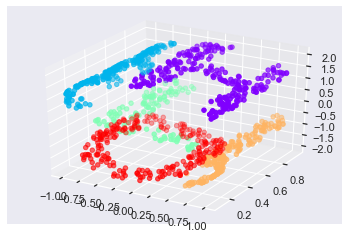

In [25]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection ='3d')
ax.scatter3D(XS[:, 0], XS[:,1], XS[:,2],
            **colorize)

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

(-1.3904556323554296,
 1.2493637628504923,
 -2.3855494181659127,
 2.1899859123555587)

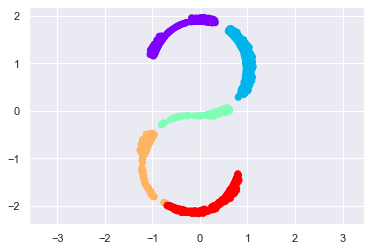

In [26]:
from sklearn.manifold import MDS   #it takes time to calculate.
model = MDS(n_components =2, random_state =2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')

The best two-dimensional linear embeding does not unwrap the S-curve, but instead throws out the original y-axis.
# Nonlinear Manifolds: Locally Linear Embedding
How can we move forward here? Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding. But what if we instead modified the algorithm such that it only preserves distances between nearby points? The resulting embedding would be closer to what we want.

Here each faint line represents a distance that should be preserved in the embedding. On the left is a representation of the model used by MDS: it tries to preserve the distances between each pair of points in the dataset. On the right is a representation of the model used by a manifold learning algorithm called locally linear embedding (LLE): rather than preserving all distances, it instead tries to preserve only the distances between neighboring points: in this case, the nearest 100 neighbors of each point.

Thinking about the left panel, we can see why MDS fails: there is no way to flatten this data while adequately preserving the length of every line drawn between the two points. For the right panel, on the other hand, things look a bit more optimistic. We could imagine unrolling the data in a way that keeps the lengths of the lines approximately the same. This is precisely what LLE does, through a global optimization of a cost function reflecting this logic.

LLE comes in a number of flavors; here we will use the modified LLE algorithm to recover the embedded two-dimensional manifold. In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

(0.15, -0.15)

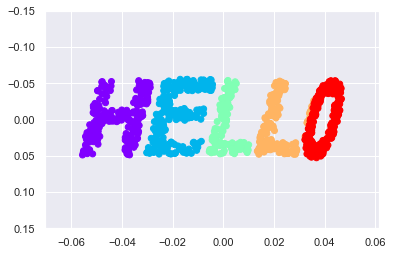

In [28]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors = 100, n_components =2, method ='modified', 
                              eigen_solver ='dense')

out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:,0], out[:,1], **colorize)
ax.set_ylim(0.15, -0.15)

The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!
# Some Thoughts on Manifold Methods
Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

1.  In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.

2.  In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components. (not robust)

3. The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.

4. In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.

5. In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.

6. In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).

7. With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.

Scikit-Learn implements several common variants of manifold learning beyond Isomap and LLE: the Scikit-Learn documentation has a nice discussion and comparison of them. Based on my own experience, I would give the following recommendations:

1. For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially modified LLE), perform very well. This is implemented in sklearn.manifold.LocallyLinearEmbedding.

2. For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in sklearn.manifold.Isomap

3. For data that is highly clustered, t-distributed stochastic neighbor embedding (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in sklearn.manifold.TSNE.

If you're interested in getting a feel for how these work, I'd suggest running each of the methods on the data in this section.

# Example: Isomap on Faces
One place manifold learning is often used is in understanding the relationship between high-dimensional data points. A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

Here let's apply Isomap on some faces data. We will use the Labeled Faces in the Wild dataset, which we previously saw in In-Depth: Support Vector Machines and In Depth: Principal Component Analysis. Running this command will download the data and cache it in your home directory for later use:

In [29]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person = 30)
faces.data.shape   #(2370, 2914)

(2370, 2914)

We have 2,370 images, each with 2,914 pixels. In other words, the images can be thought of as data points in a 2,914-dimensional space!

Let's quickly visualize several of these images to see what we're working with:

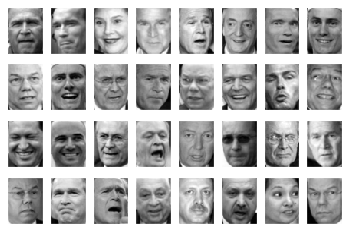

In [31]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[])) #4行8列，没坐标轴
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

In [32]:
ax.flat

In [37]:
type(faces.data)#.shape

numpy.ndarray

We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images. One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

Text(0, 0.5, 'cumulative variance')

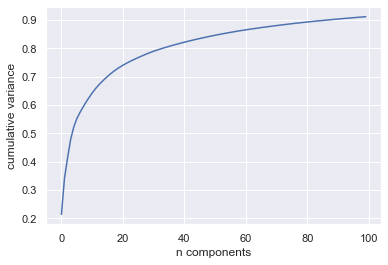

In [42]:
from sklearn.decomposition import PCA as RandomizedPCA #  RandomizedPCA is simplified to PCA
model = RandomizedPCA(100).fit(faces.data)  #前100个PC
plt.plot(np.cumsum(model.explained_variance_ratio_)) #cumulated summation of variance explianed

plt.xlabel('n components')
plt.ylabel('cumulative variance')

In [43]:
model.explained_variance_ratio_

array([0.21441565, 0.12699051, 0.07176161, 0.06514196, 0.0431511 ,
       0.02991823, 0.02129359, 0.01892981, 0.01819789, 0.01631755,
       0.01585596, 0.01408954, 0.01267515, 0.01111255, 0.01077977,
       0.00975797, 0.00939748, 0.00856475, 0.00772376, 0.00718387,
       0.00634556, 0.00620564, 0.00573983, 0.00541104, 0.00500339,
       0.00499172, 0.00480887, 0.00463018, 0.00449457, 0.00426539,
       0.0040193 , 0.00374676, 0.00347083, 0.00345875, 0.00323445,
       0.00320207, 0.00304022, 0.00301215, 0.00297173, 0.00287857,
       0.00275233, 0.00272224, 0.00269819, 0.00265281, 0.00246041,
       0.00244649, 0.00240935, 0.00236103, 0.00232632, 0.0022332 ,
       0.00220023, 0.00212927, 0.00209501, 0.00200056, 0.00197264,
       0.00195177, 0.00190076, 0.0018696 , 0.0017621 , 0.00171693,
       0.00169082, 0.00165126, 0.00162075, 0.0015655 , 0.00154935,
       0.00152169, 0.00150699, 0.00143864, 0.00142925, 0.00140937,
       0.00136527, 0.00135642, 0.00132316, 0.00131337, 0.00128

We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components.

When this is the case, nonlinear manifold embeddings like LLE and Isomap can be helpful. We can compute an Isomap embedding on these faces using the same pattern shown before:

In [44]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)  #fit_transform相当于保留了预处理标准化时候的参数，可以便于后续对于新数据的同参数处理
#Hence, every sklearn's transform's fit() just calculates the parameters (e.g. μ and σ in case of StandardScaler) 
# and saves them as an internal objects state. 
# Afterwards, you can call its transform() method to apply the transformation to a particular set of examples.
# fit_transform() joins these two steps and is used for the initial fitting of parameters on the training set x, but it also returns a transformed x′.
# Internally, it just calls first fit() and then transform() on the same data.
proj.shape

(2370, 2)

The output is a two-dimensional projection of all the input images. To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:

In [55]:
from matplotlib import offsetbox

def plot_components(data, model, images = None, ax=None,
                   thumb_frac = 0.05, cmap = 'gray'):
    ax = ax or plt.gca() #gca: Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    proj = model.fit_transform(data) #fit model (Isomap)
    
    ax.plot(proj[:, 0], proj[:, 1], '.k') #二维画图
    
    if images is not None:
        min_dist_2 = (thumb_frac*max(proj.max(0)-proj.min(0)))**2  #算一下第一维的range，再放缩一些
        shown_images = np.array([2*proj.max(0)]) #proj 2D, 第一维ma'x
        
        for i in range(data.shape[0]): #2371, n
            dist = np.sum((proj[i]-shown_images)**2, 1) #data i 到shown_images的实际距离
            if np.min(dist) <min_dist_2:
                #don't show ponits that are too close
                continue
                
            shown_images = np.vstack([shown_images, proj[i]]) #Stack arrays in sequence vertically (row wise).
            imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[i], cmap = cmap),
            proj[i])
            
            #The OffsetBox is a simple container artist. 
            #The child artist are meant to be drawn at a relative position to its parent. 
            #The [VH]Packer, DrawingArea and TextArea are derived from the OffsetBox.
            
            ax.add_artist(imagebox) #Add an Artist to the axes, and return the artist.


SyntaxError: invalid syntax (<ipython-input-55-5280a7d16256>, line 4)

calling this function now, we see the result:

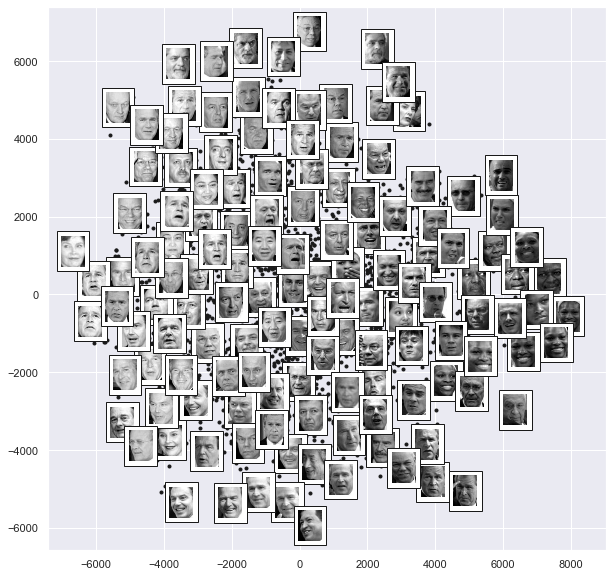

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_components(faces.data,
               model = Isomap(n_components =2),
               images = faces.images[:, ::2, ::2])

The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top. This gives us a nice visual indication of some of the fundamental features in our data. 只保留两维度的信息，好像是明暗度和face上下方向。

We could then go on to classify this data (perhaps using manifold features as inputs to the classification algorithm) as we did in In-Depth: Support Vector Machines.

In [60]:
proj.max(0)

array([8277.7804276 , 6760.79479945])

# Example: Visualizing Structure in Digits
As another example of using manifold learning for visualization, let's take a look at the MNIST handwritten digits set. This data is similar to the digits we saw in In-Depth: Decision Trees and Random Forests, but with many more pixels per image. It can be downloaded from http://mldata.org/ with the Scikit-Learn utility:

In [65]:
from sklearn.datasets import fetch_openml #fetch_mldata已经被弃用
mnist = fetch_openml('mnist_784')
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py
mnist.data.shape   #手写数据库

(70000, 784)

This consists of 70,000 images, each with 784 pixels (i.e. the images are 28×28). As before, we can take a look at the first few images:

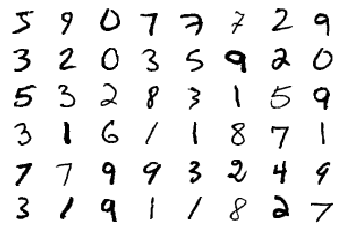

In [78]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))

for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r') #728=28X28
    
    
#ax.flat is not a function, it's an attribute of the numpy.ndarray: 
# numpy.ndarray.flat
# ndarray.flat A 1-D iterator over the array.
# This is a numpy.flatiter instance, which acts similarly to,
# but is not a subclass of, Python’s built-in iterator object.

This gives us an idea of the variety of handwriting styles in the dataset.

Let's compute a manifold learning projection across the data. For speed here, we'll only use 1/30 of the data, which is about ~2000 points (because of the relatively poor scaling of manifold learning, I find that a few thousand samples is a good number to start with for relatively quick exploration before moving to a full calculation):

ValueError: RGBA values should be within 0-1 range

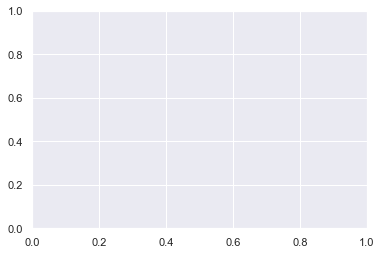

In [83]:
# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)

plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

# RGBA values should be within 0-1 range
# Your clusters are strings. Prior to matplotlib 2.1 arrays were converted to numbers coincidentally such that the code would run. 
# From matplotlib 2.1 you need to supply numbers in order to have them interpreted as such. E.g.

The resulting scatter plot shows some of the relationships between the data points, but is a bit crowded. We can gain more insight by looking at just a single number at a time:

ValueError: Found array with 0 sample(s) (shape=(0, 784)) while a minimum of 1 is required.

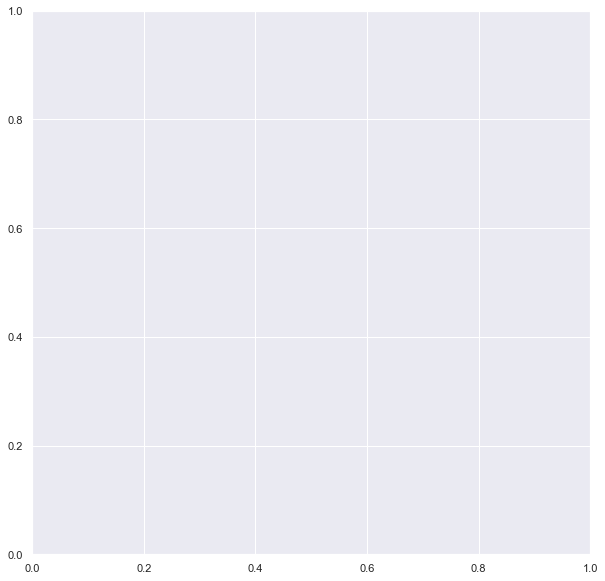

In [77]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')

plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')


The result gives you an idea of the variety of forms that the number "1" can take within the dataset. The data lies along a broad curve in the projected space, which appears to trace the orientation of the digit. As you move up the plot, you find ones that have hats and/or bases, though these are very sparse within the dataset. The projection lets us identify outliers that have data issues: for example, pieces of the neighboring digits that snuck into the extracted images.

Now, this in itself may not be useful for the task of classifying digits, but it does help us get an understanding of the data, and may give us ideas about how to move forward, such as how we might want to preprocess the data before building a classification pipeline.